plot correlation between one feature and the target score

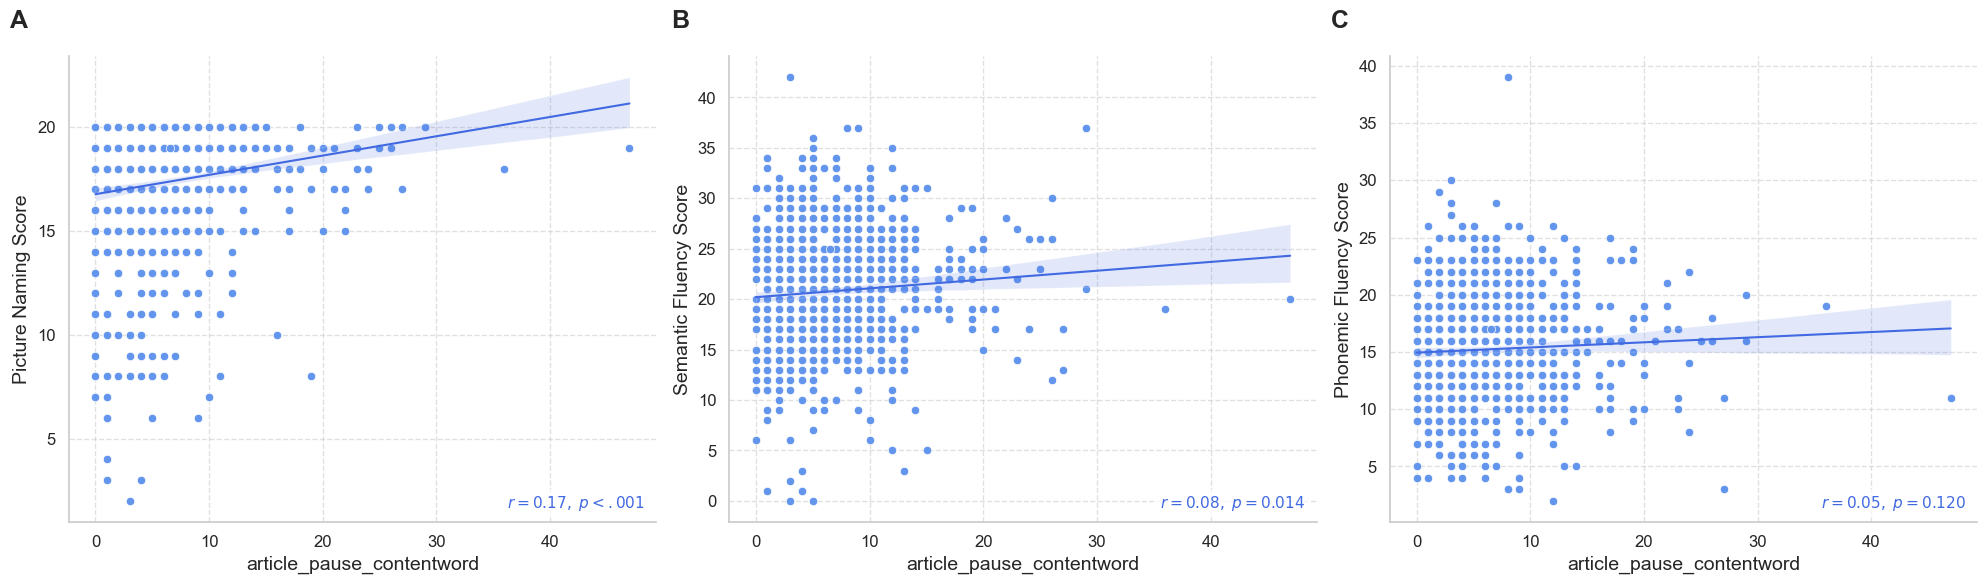

,Panel,Score,N
0,A,PictureNamingScore,988
1,B,SemanticFluencyScore,1000
2,C,PhonemicFluencyScore,1000


In [6]:
# setup
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from scipy.stats import pearsonr
from matplotlib.ticker import MultipleLocator

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from regression.plotting_helpers import format_title

# define variables
task_name = "picnicScene"
feature_name = "article_pause_contentword"
targets = ["PictureNamingScore", "SemanticFluencyScore", "PhonemicFluencyScore"]

# load data
scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
demographics_path = os.path.join(GIT_DIRECTORY, "data/demographics_data.csv")
features = pd.read_csv(features_path)
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)

# saving dir
save_dir = os.path.join(GIT_DIRECTORY, "results", "plots", "feature_vs_target")
os.makedirs(save_dir, exist_ok=True)

# setup plot grid
fig, axes = plt.subplots(1, len(targets), figsize=(20, 6), sharex=False, sharey=False)
sns.set(style="whitegrid")

panel_labels = ["A", "B", "C"]
N_summary = []

for ax, target, label in zip(axes, targets, panel_labels):
    # merge data for this target
    df = pd.merge(features, demographics, on="Subject_ID", how="left")
    df = pd.merge(df, scores[["Subject_ID", target]], on="Subject_ID", how="left")
    df = df[[feature_name, target]].dropna()

    # correlation
    r, p = pearsonr(df[feature_name], df[target])
    p_text = "< .001" if p < 0.001 else f"= {p:.3f}"
    corr_text = rf"$r = {r:.2f},\ p {p_text}$"

    # scatter + regression line
    sns.scatterplot(data=df, x=feature_name, y=target,
                    color="cornflowerblue", ax=ax)
    sns.regplot(data=df, x=feature_name, y=target,
                scatter=False, color="royalblue", ci=95,
                line_kws={"linewidth": 1.5}, ax=ax)

    # formatting
    ax.set_xlabel(feature_name, fontsize=14)
    ax.set_ylabel(format_title(target), fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    sns.despine(ax=ax)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.yaxis.set_major_locator(MultipleLocator(5))

    # correlation text
    ax.text(
        0.98, 0.02, corr_text,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=11, style="italic", color="royalblue",
        bbox=dict(facecolor="white", alpha=0.7,
                  edgecolor="none", boxstyle="round,pad=0.3")
    )

    N_summary.append([label, target, len(df)])


for ax, label in zip(axes, panel_labels):
    ax.text(
        -0.1, 1.05, label, transform=ax.transAxes,
        fontsize=18, fontweight="bold", va="bottom", ha="left"
    )

plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"{feature_name}_all_scores_correlation_{task_name}.png"),
            dpi=600, bbox_inches="tight")
plt.show()
N_table = pd.DataFrame(N_summary, columns=["Panel", "Score", "N"])
display(N_table)

In [4]:
# add correlation table for all features

# setup
import sys
import os
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY

task_name = "journaling"
targets = ["PictureNamingScore", "SemanticFluencyScore", "PhonemicFluencyScore"]

scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered2.csv")

scores = pd.read_csv(scores_path)[["Subject_ID", *targets]]
features = pd.read_csv(features_path)

df = pd.merge(features, scores, on="Subject_ID", how="inner").dropna()

# compute correlations
corr_results = pd.DataFrame({"feature": [c for c in features.columns if c != "Subject_ID"]})

for target in targets:
    r_values, p_values = [], []

    for feature in corr_results["feature"]:
        r, p = pearsonr(df[feature], df[target])
        r_values.append(r)
        p_values.append(p)

    # Holm–Bonferroni correction within each target
    _, p_corr, _, _ = multipletests(p_values, method="holm")

    # add results as new columns
    corr_results[f"r_{target}"] = r_values
    corr_results[f"p_{target}"] = p_corr

# save csv file
out_path = os.path.join(GIT_DIRECTORY, "results", "correlations", f"{task_name}_feature_score_correlations.csv")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
corr_results.to_csv(out_path, index=False)

print(f"saved correlation results to: {out_path}")
display(corr_results.head())


saved correlation results to: /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/correlations/journaling_feature_score_correlations.csv


,feature,r_PictureNamingScore,p_PictureNamingScore,r_SemanticFluencyScore,p_SemanticFluencyScore,r_PhonemicFluencyScore,p_PhonemicFluencyScore
0,n_words,0.145732,0.000185,0.118067,0.007842,0.042910,1.0
1,mattr_10,0.160125,0.000022,0.115835,0.010054,0.014914,1.0
2,mattr_30,0.168628,0.000005,0.108078,0.023851,0.006966,1.0
3,filler_word_ratio,0.109941,0.019784,-0.018135,1.000000,0.009080,1.0
4,average_word_length,0.082319,0.268243,0.045111,1.000000,0.005946,1.0


saved r to: /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/correlations/combined_feature_score_correlations_r.csv
saved p (Holm-corrected) to: /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/correlations/combined_feature_score_correlations_p_corr.csv
saved heatmap to: /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/correlations/combined_correlations_heatmap_signed_toplabels.png


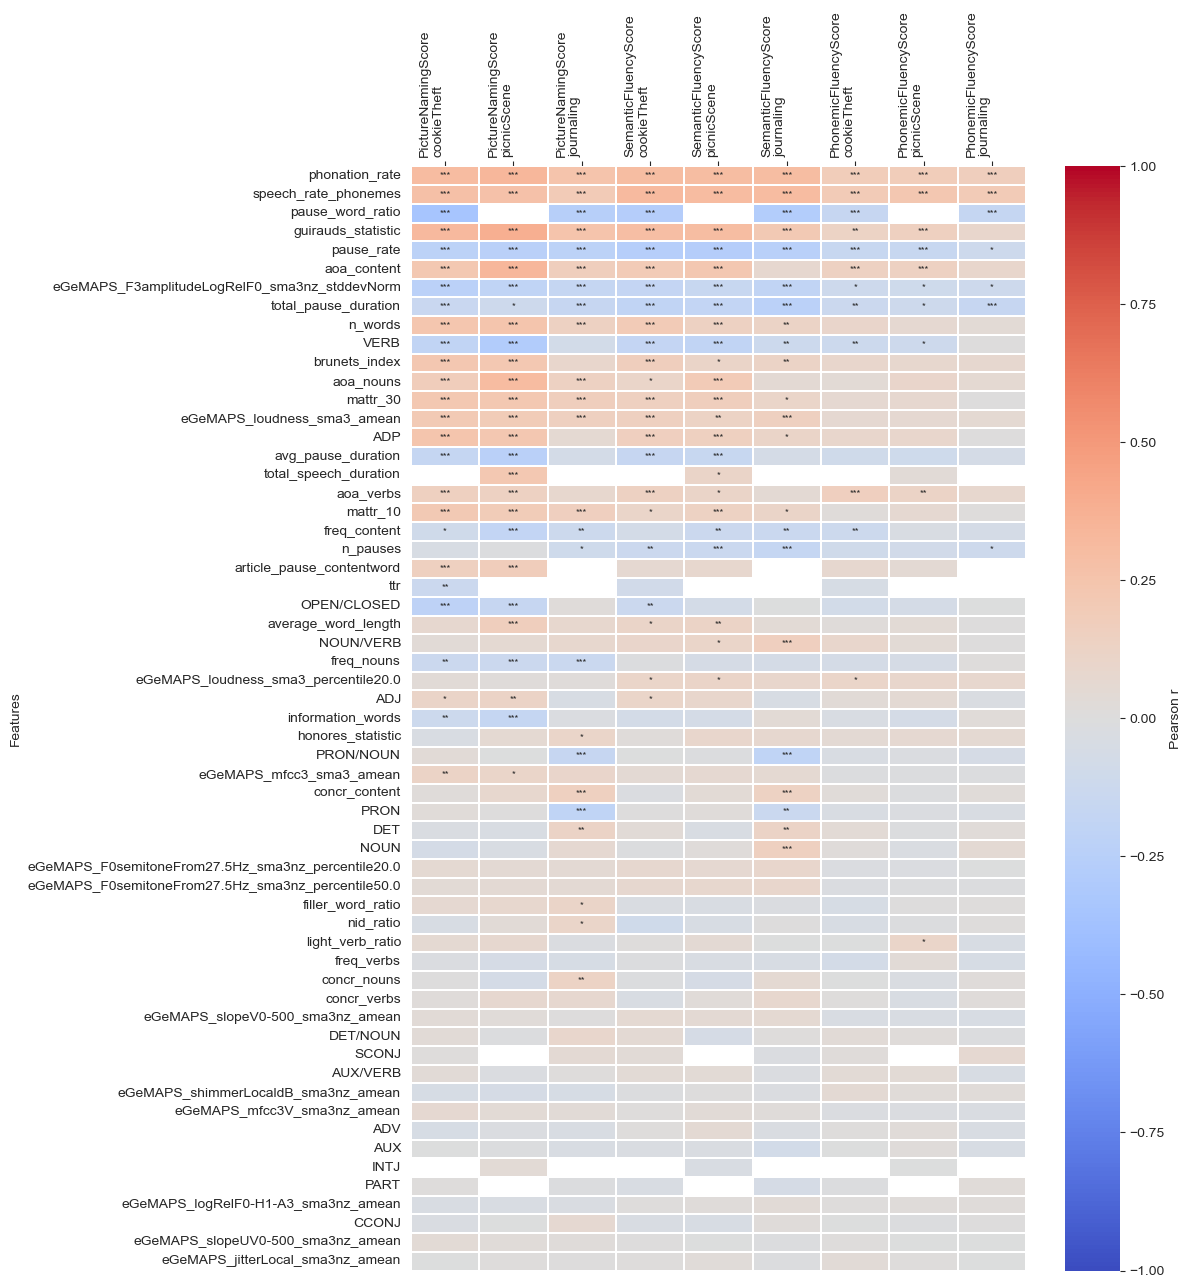

In [6]:
# === Combined correlation heatmap across tasks × scores ===
import sys, os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")
from config.constants import GIT_DIRECTORY

# ------------------ config ------------------
TASKS   = ["cookieTheft","picnicScene","journaling"]
SCORES  = ["PictureNamingScore","SemanticFluencyScore","PhonemicFluencyScore"]

ORDERED_COLS = [
    ("PictureNamingScore","cookieTheft"), ("PictureNamingScore","picnicScene"), ("PictureNamingScore","journaling"),
    ("SemanticFluencyScore","cookieTheft"), ("SemanticFluencyScore","picnicScene"), ("SemanticFluencyScore","journaling"),
    ("PhonemicFluencyScore","cookieTheft"), ("PhonemicFluencyScore","picnicScene"), ("PhonemicFluencyScore","journaling"),
]

ABS_VALUES_FOR_HEATMAP = False   # set True for SHAP-style (|r|) single-color map
TOP_N_FEATURES = None            # e.g., 60 to cap height; None = show all

OUTDIR = os.path.join(GIT_DIRECTORY, "results", "correlations")
os.makedirs(OUTDIR, exist_ok=True)

# ------------------ load base scores ------------------
scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")
scores = pd.read_csv(scores_path)[["Subject_ID", *SCORES]]

# ------------------ compute correlations per task ------------------
all_r = {}   # (score, task) -> pd.Series of r indexed by feature
all_p = {}   # (score, task) -> pd.Series of p_corrected indexed by feature
all_features = set()

for task in TASKS:
    features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task}_filtered2.csv")
    if not os.path.exists(features_path):
        print(f"[warn] missing features for task: {task} -> {features_path}")
        continue

    feats = pd.read_csv(features_path)
    # merge scores and features
    df = pd.merge(feats, scores, on="Subject_ID", how="inner").dropna()

    # feature columns
    feat_cols = [c for c in feats.columns if c != "Subject_ID"]
    all_features.update(feat_cols)

    for score in SCORES:
        r_vals, p_vals = [], []
        for f in feat_cols:
            r, p = pearsonr(df[f], df[score])
            r_vals.append(r)
            p_vals.append(p)

        # Holm correction within each (task, score)
        _, p_corr, _, _ = multipletests(p_vals, method="holm")

        all_r[(score, task)] = pd.Series(r_vals, index=feat_cols, dtype=float)
        all_p[(score, task)] = pd.Series(p_corr, index=feat_cols, dtype=float)

# ------------------ assemble wide matrices ------------------
all_features = sorted(all_features)
col_tuples = [c for c in ORDERED_COLS if c in all_r]  # keep only available columns

R = pd.DataFrame(index=all_features, columns=pd.MultiIndex.from_tuples(col_tuples, names=["score","task"]), dtype=float)
P = pd.DataFrame(index=all_features, columns=pd.MultiIndex.from_tuples(col_tuples, names=["score","task"]), dtype=float)

for col in col_tuples:
    r_series = all_r.get(col)
    p_series = all_p.get(col)
    if r_series is not None:
        R.loc[r_series.index, col] = r_series.values
    if p_series is not None:
        P.loc[p_series.index, col] = p_series.values

# ------------------ sort features by mean |r| across all columns ------------------
mean_abs = R.abs().mean(axis=1, skipna=True)
R_sorted = R.loc[mean_abs.sort_values(ascending=False).index]
P_sorted = P.loc[R_sorted.index]

if TOP_N_FEATURES is not None:
    R_sorted = R_sorted.head(TOP_N_FEATURES)
    P_sorted = P_sorted.loc[R_sorted.index]

# ------------------ save CSVs ------------------
R_out = os.path.join(OUTDIR, "combined_feature_score_correlations_r.csv")
P_out = os.path.join(OUTDIR, "combined_feature_score_correlations_p_corr.csv")
R_sorted.to_csv(R_out)
P_sorted.to_csv(P_out)
print(f"saved r to: {R_out}")
print(f"saved p (Holm-corrected) to: {P_out}")

# ------------------ build heat map data + significance labels ------------------
plot_data = R_sorted.copy()

def stars(p):
    if pd.isna(p):
        return ""
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# fix FutureWarning (use .map instead of .applymap)
annot = P_sorted.map(stars)

if ABS_VALUES_FOR_HEATMAP:
    plot_data = plot_data.abs()
    cmap = plt.get_cmap("Reds").copy()
    center = None
    vmin, vmax = 0, 1
else:
    cmap = plt.get_cmap("coolwarm").copy()
    center = 0
    vmin, vmax = -1, 1

# make NaNs pure white
cmap.set_bad("white")

# ------------------ plot ------------------
plt.figure(figsize=(12, max(6, 0.22 * len(plot_data))))
mask = plot_data.isna()  # mask out NaN values
ax = sns.heatmap(
    plot_data,
    mask=mask,
    cmap=cmap,
    vmin=vmin, vmax=vmax, center=center,
    linewidths=0.2, linecolor="white",
    cbar_kws={"label": "Pearson r" if not ABS_VALUES_FOR_HEATMAP else "|r|"},
    annot=annot.astype(str),
    fmt="",
    annot_kws={"fontsize": 7, "ha": "center", "va": "center"},
    square=False
)

# === improved axis labels ===
# flatten MultiIndex -> "Score (Task)" style
xticklabels = [f"{score}\n{task}" for score, task in plot_data.columns]
ax.set_xticklabels(xticklabels, rotation=90, ha="left", rotation_mode="anchor")

# move x labels to top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# optional: add a bit of space above the labels
plt.subplots_adjust(top=0.90)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_ylabel("Features")
ax.set_xlabel("")

plt.tight_layout()
fig_path = os.path.join(OUTDIR, f"combined_correlations_heatmap_{'abs' if ABS_VALUES_FOR_HEATMAP else 'signed'}_toplabels.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"saved heatmap to: {fig_path}")
plt.show()
